In [1]:
%load_ext autoreload
%load_ext autotime
%autoreload 2

## Imports & Settings

In [2]:
import os, sys

# setting project path
gparent = os.path.join(os.pardir, os.pardir)
sys.path.append(gparent)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# setting style
sns.set_theme('talk')
plt.style.use('fivethirtyeight')
sns.set_palette('GnBu_r')
pd.options.display.max_rows = 300

from src import helper_functions as f
from src import visualizations as v
from src import class_Database as d

time: 2 s


## Creating The Database

In [3]:
# creating database & database class instance
database_name = 'outcomes.db'
db = d.Database(database_name)

time: 1.34 ms


**Run The Cell Below Once And Then Comment Out**

In [4]:
# file_name = 'anonymisedData.zip'
# db.populate(file_name, database_name)

time: 976 µs


## Half Term Data

In [5]:
# creating dataframe
df = db.data_prep_half(120)

# cleaning data frame
drops = ['row_id', 'studied_credits',
         'id_site', 'sum_click', 'date_sub', 'date',
         'score','course_length', 'date_registration',
         'date_unregistration', 'max_date', 'activity_level']

df = db.pipe_cleaner_wa(df, drops).reset_index(drop=True)

time: 10.4 s


In [6]:
# saving columns as series for use in error data frame
final_result = df['final_result'].copy()
code_module = df['code_module'].copy()
code_presentation = df['code_presentation'].copy()

time: 1.94 ms


In [7]:
# dropping columns
df = df.drop(['final_result', 'code_presentation',
              'code_module', 'id_student'], axis=1)

time: 4.7 ms


## Splitting The Data

In [8]:
# splitting data & target
X, y = f.X_y(df)

time: 4.08 ms


In [9]:
# splitting training and holdout data
X_training, X_holdout, y_training, y_holdout = f.test_train(X, y)

time: 14 ms


## Loading Model

In [16]:
model = f.load_model('final')

time: 177 ms


## Counter Factual Data Frame

In [30]:
cf_df = X_holdout.copy()

time: 3.78 ms


In [31]:
cf_df['target'] = y_holdout

time: 1.4 ms


In [32]:
cf_df['prediction'] =  model.predict(X_holdout)

time: 53.1 ms


In [40]:
cf_df['lable_error'] = np.where(cf_df.target != cf_df.prediction, 1, 0)

time: 1.27 ms


In [41]:
cf_df.head()

,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,disability,weighted_ave,mean_score,median_score,sum_activity,course_load,target,prediction,lable_error
8717,Male,North Western Region,HE Qualification,80-90%,35-55,0.0,No,194.0,81.750000,81.0,1269.0,Light,0.0,0.0,0
9831,Male,East Anglian Region,Lower Than A Level,60-70%,35-55,0.0,Yes,131.4,82.666667,82.0,1481.0,Light,1.0,0.0,1
500,Male,South East Region,Lower Than A Level,40-50%,35-55,0.0,No,62.0,61.333333,63.0,2144.0,Light,0.0,1.0,1
15312,Male,Yorkshire Region,A Level or Equivalent,40-50%,0-35,0.0,Yes,166.0,71.500000,78.5,2204.0,Heavy,0.0,0.0,0
17799,Male,North Western Region,Lower Than A Level,10-20%,35-55,0.0,Yes,0.0,87.500000,87.5,834.0,Medium,1.0,0.0,1


time: 13.2 ms


In [46]:
errors = cf_df.lable_error.value_counts(normalize=True)

0    0.759712
1    0.240288
Name: lable_error, dtype: float64

time: 3.51 ms


<AxesSubplot:xlabel='sum_activity', ylabel='lable_error'>

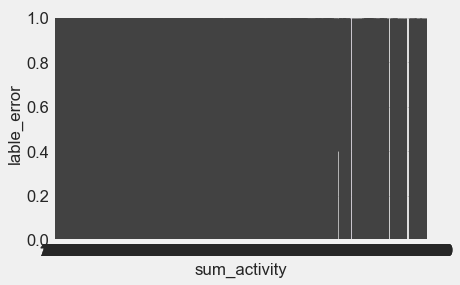

time: 1min 2s


In [44]:
fig, ax = plt.subplots()
sns.barplot(data=errors, x='sum_activity', y='lable_error')